# Вступительное задание в ML секту

## Текст задания
Необходимо предсказать популярность песни на Spotify по её характеристикам c помощью датасета SpotifyFeatures.
Можно начать с модели линейной регрессии...

### Импорт и обработка данных

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [2]:
!gdown 1yKs0teWyaNzcJAXiGcajyInyymMQdzxB

Downloading...
From: https://drive.google.com/uc?id=1yKs0teWyaNzcJAXiGcajyInyymMQdzxB
To: /content/SpotifyFeatures.csv
100% 33.7M/33.7M [00:00<00:00, 37.1MB/s]


In [3]:
original_dataset = pd.read_csv("SpotifyFeatures.csv")

original_dataset.head(3)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.0,C,0.103,-13.879,Minor,0.0362,99.488,5/4,0.368


In [4]:
dataset = original_dataset.copy(deep=True)

#### Убираем ненужные параметры, бинарные приводим к численным

In [5]:
dataset.drop(columns=["artist_name", "track_name", "track_id"], inplace=True)
dataset.replace({"mode": {"Major": 1, "Minor": 0}}, inplace=True)

dataset.head(3)

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,1,0.0525,166.969,4/4,0.814
1,Movie,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,0,0.0868,174.003,4/4,0.816
2,Movie,3,0.952,0.663,170267,0.131,0.0,C,0.103,-13.879,0,0.0362,99.488,5/4,0.368


#### Используем One Hot Encoding для небинарных строчных параметров

In [6]:
one_hot_encoding_columns = ["genre", "key", "time_signature"]
for column in one_hot_encoding_columns:
    encoded_column = pd.get_dummies(dataset[column])
    dataset = pd.concat([dataset, encoded_column], axis=1)
    dataset.drop(column, axis=1, inplace=True)

dataset.head(3)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,E,F,F#,G,G#,0/4,1/4,3/4,4/4,5/4
0,0,0.611,0.389,99373,0.910,0.0,0.346,-1.828,1,0.0525,...,0,0,0,0,0,0,0,0,1,0
1,1,0.246,0.590,137373,0.737,0.0,0.151,-5.559,0,0.0868,...,0,0,1,0,0,0,0,0,1,0
2,3,0.952,0.663,170267,0.131,0.0,0.103,-13.879,0,0.0362,...,0,0,0,0,0,0,0,0,0,1


#### Т.к. данные неоднородные, используем Standard Scaler

In [7]:
scaler_columns = dataset.columns.tolist()
scaler_columns.remove("popularity")

scaler = StandardScaler()
scaler.fit(dataset[scaler_columns])
scaled_columns = scaler.transform(dataset[scaler_columns])
dataset[scaler_columns] = scaled_columns

dataset.head(3)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,...,E,F,F#,G,G#,0/4,1/4,3/4,4/4,5/4
0,0,0.683376,-0.890935,-1.141368,1.286908,-0.489819,0.660661,1.290703,0.730526,-0.367970,...,-0.284179,-0.308958,-0.264547,-0.357629,-0.263961,-0.005863,-0.106458,-0.339966,0.399024,-0.151742
1,1,-0.345467,0.191994,-0.821867,0.630249,-0.489819,-0.322835,0.668683,-1.368876,-0.183082,...,-0.284179,-0.308958,3.780043,-0.357629,-0.263961,-0.005863,-0.106458,-0.339966,0.399024,-0.151742
2,3,1.644570,0.585296,-0.545298,-1.669954,-0.489819,-0.564927,-0.718402,-1.368876,-0.455832,...,-0.284179,-0.308958,-0.264547,-0.357629,-0.263961,-0.005863,-0.106458,-0.339966,-2.506116,6.590154


In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#### Реализуем функции для удобства

In [9]:
def evaluate_model(y_test: pd.Series,
                   y_pred: np.array) -> tuple[float, float, float]:

    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2


def create_confidence_interval_df(y_test: pd.Series,
                                  y_pred: np.array,
                                  alpha: int = 0.05) -> pd.DataFrame:

    n = len(y_pred)
    degrees_of_freedom = n - 1
    standard_error = np.std(y_pred, ddof=1) / np.sqrt(n)
    t_value = stats.t.ppf(1 - alpha / 2, degrees_of_freedom)
    interval = t_value * standard_error
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval

    result_df = pd.DataFrame({
        "y_test": y_test,
        "lower_bound": lower_bound,
        "y_pred": y_pred,
        "upper_bound": upper_bound
    })

    return result_df


def plot_result_sample(result_df: pd.DataFrame,
                       sample_size: int = 100,
                       sample_seed: int = 42) -> None:

    result_sample = result_df.sample(sample_size, random_state=sample_seed).reset_index(drop=True)
    fig, ax = plt.subplots()

    ax.scatter(result_sample.index, result_sample.y_test, label="y_test", c="blue", s=30)
    ax.errorbar(result_sample.index, result_sample.y_pred,
                yerr=(result_sample["upper_bound"] - result_sample["lower_bound"]) / 2,
                color="orange",  ecolor="lightgreen", capsize=6,
                label="confidence_interval", fmt="o", elinewidth=3)


    ax.legend()
    plt.xlabel("Index")
    plt.ylabel("Popularity")
    plt.show()


def calculate_feature_importance(X_train: pd.DataFrame,
                                 one_hot_encoded_columns: list,
                                 original_dataset: pd.DataFrame,
                                 model) -> pd.DataFrame:

    feature_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": np.abs(model.coef_)
    })

    for column in one_hot_encoded_columns:
        unique_encodings = original_dataset[column].unique()
        encodings_filter = feature_importance.feature.isin(unique_encodings)
        encodings_mean = feature_importance[encodings_filter].importance.mean()

        feature_importance = feature_importance[~encodings_filter]
        feature_importance = pd.concat([feature_importance, pd.DataFrame({
            "feature": column,
            "importance": encodings_mean}, index=[0])])

    return feature_importance.reset_index(drop=True).sort_values(by="importance", ascending=False)

#### Разделим данные на тренировочную и тестовую выборки

In [10]:
X = dataset.drop(columns=["popularity"])
y = dataset.popularity

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

### Модель Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

#### Обучим модель

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#### Оценим точность

In [13]:
mse_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr)

print(f"MSE: {mse_lr:.3f}\nRMSE: {rmse_lr:.3f}\nR2: {r2_lr:.3f}")

MSE: 92.717
RMSE: 9.629
R2: 0.720


#### Рассмотрим результаты с учётом доверительного интервала

In [14]:
confidence_interval_lr = create_confidence_interval_df(y_test, y_pred_lr)

confidence_interval_lr.head(5)

,y_test,lower_bound,y_pred,upper_bound
788,45,45.433462,45.631365,45.829267
207109,25,34.322134,34.520037,34.717939
138644,19,35.500845,35.698748,35.896650
37164,29,39.198111,39.396013,39.593916
174351,17,20.877066,21.074968,21.272871


#### Построим график полученных результатов

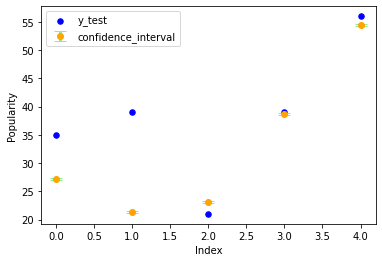

In [15]:
plot_result_sample(confidence_interval_lr, 5)

#### Оценим важность каждого признака

In [16]:
calculate_feature_importance(X_train, one_hot_encoding_columns, original_dataset, lr)

,feature,importance
12,key,3.758565e+12
11,genre,2.845988e+12
13,time_signature,2.211617e+12
6,loudness,1.015927e+00
8,speechiness,6.699770e-01
5,liveness,4.911363e-01
1,danceability,3.452714e-01
4,instrumentalness,3.257773e-01
10,valence,3.080239e-01
3,energy,3.050868e-01


#### Вывод по эксперименту
Можно заметить, что точность линейной регрессии не впечатляет. Даже с учётом доверительного интервала
погрешность весьма велика. Также можно обратить внимание на огромные коэффициенты перед признаками,
на которые был применён One Hot Encoding, что не является хорошим знаком. Попробуем исправить последнее
при помощи моделей линейной регрессии с встроенной регуляризацией - к примеру, Ridge.


### Модель RidgeCV

In [17]:
from sklearn.linear_model import RidgeCV

#### Обучим модель

In [18]:
rr = RidgeCV()
rr.fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)

print("Best alpha value:", rr.alpha_)

Best alpha value: 10.0


#### Оценим точность

In [19]:
mse_rr, rmse_rr, r2_rr = evaluate_model(y_test, y_pred_rr)

print(f"MSE: {mse_rr:.3f}\nRMSE: {rmse_rr:.3f}\nR2: {r2_rr:.3f}")

MSE: 92.717
RMSE: 9.629
R2: 0.720


#### Рассмотрим результаты с учётом доверительного интервала

In [20]:
confidence_interval_rr = create_confidence_interval_df(y_test, y_pred_rr)

confidence_interval_rr.head(5)

,y_test,lower_bound,y_pred,upper_bound
788,45,45.430925,45.628785,45.826645
207109,25,34.338876,34.536735,34.734595
138644,19,35.505054,35.702914,35.900773
37164,29,39.193076,39.390936,39.588796
174351,17,20.863611,21.061470,21.259330


#### Построим график полученных результатов

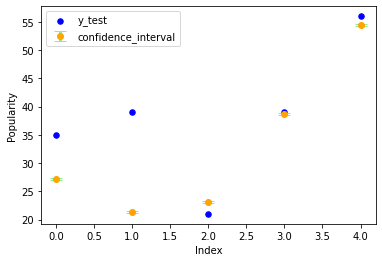

In [21]:
plot_result_sample(confidence_interval_rr, 5)

#### Оценим важность каждого признака

In [22]:
calculate_feature_importance(X_train, one_hot_encoding_columns, original_dataset, rr)

,feature,importance
11,genre,2.354536
6,loudness,1.014269
8,speechiness,0.672711
5,liveness,0.490938
1,danceability,0.343962
4,instrumentalness,0.328888
10,valence,0.309909
3,energy,0.306525
7,mode,0.153641
0,acousticness,0.094706


#### Вывод по эксперименту
Можно заметить, что коэффициенты пришли в норму, но, к сожалению, сильно на точности предсказаний
это не сказалось. Делаем вывод, что линейная регрессия - не самая удачная идея для данного набора данных.
Возможно, существует нелинейная зависимость? Проверим...

### Модель Polynomial Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#### Обучим модель

In [ ]:
pipeline = Pipeline([
    ("pf", PolynomialFeatures(2)),
    ("regressor", Ridge(alpha=10))
])

pipeline.fit(X_train, y_train)
y_pred_pf = pipeline.predict(X_test)

#### Оценим точность

In [ ]:
mse_pf, rmse_pf, r2_pf = evaluate_model(y_test, y_pred_pf)

print(f"MSE: {mse_pf:.3f}\nRMSE: {rmse_pf:.3f}\nR2: {r2_pf:.3f}")

MSE: 89.369
RMSE: 9.454
R2: 0.730


#### Рассмотрим результаты с учётом доверительного интервала

In [ ]:
confidence_interval_pf = create_confidence_interval_df(y_test, y_pred_pf)

confidence_interval_pf.head(5)

,y_test,lower_bound,y_pred,upper_bound
788,45,45.557215,45.756874,45.956534
207109,25,32.043717,32.243376,32.443035
138644,19,36.109074,36.308733,36.508392
37164,29,38.619743,38.819402,39.019062
174351,17,23.182957,23.382616,23.582276


#### Построим график полученных результатов

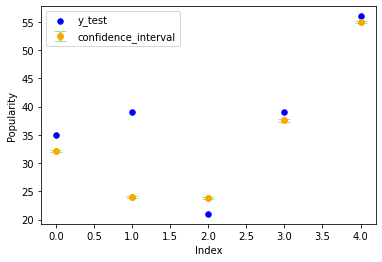

In [ ]:
plot_result_sample(confidence_interval_pf, 5)

#### Оценим важность каждого признака 
(+ попарно, т.к. степень полинома 2)

In [ ]:
pf_feature_importance = pd.DataFrame({
    "feature": pipeline.named_steps["pf"].get_feature_names_out(),
    "importance": np.abs(pipeline.named_steps["regressor"].coef_)
})

pf_feature_importance = pf_feature_importance[~(pf_feature_importance.feature == "1")]
pf_feature_importance.reset_index(drop=True).sort_values(by="importance", ascending=False)

,feature,importance
6,loudness,1.657197e+00
396,loudness Reggaeton,1.392501e+00
4,instrumentalness,1.098062e+00
283,instrumentalness Comedy,1.040084e+00
1160,Movie^2,9.686660e-01
...,...,...
1535,D# 0/4,3.328679e-06
644,A Capella 0/4,2.581615e-06
1485,B 0/4,2.211945e-06
1569,G 0/4,8.386496e-07


#### Выводы по эксперименту
Полиномиальная регрессия также не является оптимальной для нашего датасета, т.к. при маленьком значении степени R^2 даже выше, чем при использовании линейной регрессии. Если же использовать степень выше, то использование ресурсов этой моделью абсолютно неоптимально (с учётом 55 параметров и размере train ~200к объектов довольно очевидно почему).
Попробуем более продвинутые модели.

P.S. На моём ПК при использовании fit со степенью 2 сразу вылетает синий экран, из-за чего я 1 раз потерял полную работу 😢, так что пришлось провести вычисления в google colab. Запускать на свой страх и риск...

### Модель Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#### Обучим модель с подбором гиперпараметров

In [ ]:
param_grid = {
    "n_estimators": [256],
    "max_depth": [32, 64],
    "min_samples_split": [16, 32],
    "min_samples_leaf": [1],
    "max_features": ["sqrt"]
}

rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=6)
grid_search_rf.fit(X_train, y_train)
y_pred_rf = grid_search_rf.predict(X_test)

print(f"Best hyperparameters: {grid_search_rf.best_params_}")

Best hyperparameters: {'max_depth': 64, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 256}


#### Оценим точность

In [ ]:
mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

print(f"MSE: {mse_rf:.3f}\nRMSE: {rmse_rf:.3f}\nR2: {r2_rf:.3f}")

MSE: 87.045
RMSE: 9.330
R2: 0.737


#### Рассмотрим результаты с учётом доверительного интервала

In [ ]:
confidence_interval_rf = create_confidence_interval_df(y_test, y_pred_rf)

confidence_interval_rf.head(5)

,y_test,lower_bound,y_pred,upper_bound
788,45,43.863544,44.058487,44.253430
207109,25,32.238570,32.433513,32.628455
138644,19,35.078274,35.273217,35.468160
37164,29,38.378286,38.573229,38.768171
174351,17,22.864865,23.059808,23.254750


#### Построим график полученных результатов

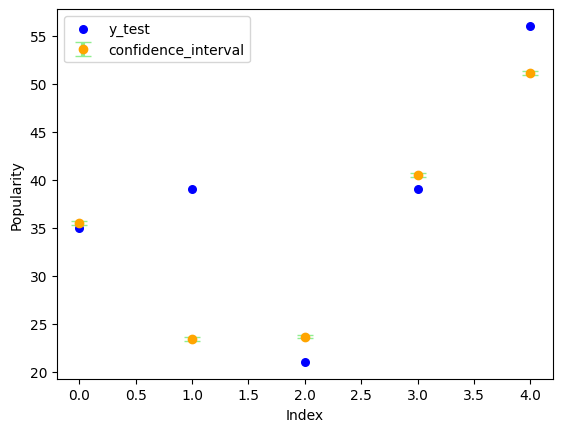

In [ ]:
plot_result_sample(confidence_interval_rf, 5)

#### Выводы по эксперименту
Модель случайного леса показала качественно лучшие результаты, чем предыдущие модели, хотя идеальными их назвать сложно. Стоит также понимать, что были подобраны не идеальные гиперпараметры, т.к. это заняло бы слишком большое количество времени и ресурсов. Но, проведя несколько экспериментов, вполне понятно, в какую сторону каждый из параметров можно улучшить. Рассмотрим модель из основного фреймфорка для ML - Keras и проведём сравнение.

### Модель MLP

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

#### Разделим train выборку, отделив validation данные

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=42)

#### Составим модель и обучим её

In [26]:
model = Sequential()
model.add(Dense(1024, input_dim=55, activation="relu", kernel_regularizer=regularizers.l2(10 ** -3)))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(10 ** -3)))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(10 ** -3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
y_pred_mlp = model.predict(X_test)

Epoch 1/50
5891/5891 [==============================] - 40s 7ms/step - loss: 122.7899 - val_loss: 93.8829
Epoch 2/50
5891/5891 [==============================] - 39s 7ms/step - loss: 113.1346 - val_loss: 91.8915
Epoch 3/50
5891/5891 [==============================] - 38s 7ms/step - loss: 111.2699 - val_loss: 92.3380
Epoch 4/50
5891/5891 [==============================] - 39s 7ms/step - loss: 109.3910 - val_loss: 91.4747
Epoch 5/50
5891/5891 [==============================] - 39s 7ms/step - loss: 108.2979 - val_loss: 93.0440
Epoch 6/50
5891/5891 [==============================] - 39s 7ms/step - loss: 107.3134 - val_loss: 90.9555
Epoch 7/50
5891/5891 [==============================] - 39s 7ms/step - loss: 106.1009 - val_loss: 90.5996
Epoch 8/50
5891/5891 [==============================] - 39s 7ms/step - loss: 105.4583 - val_loss: 90.5667
Epoch 9/50
5891/5891 [==============================] - 39s 7ms/step - loss: 103.5302 - val_loss: 89.6726
Epoch 10/50
5891/5891 [=======================

#### Графически оценим train и validation loss

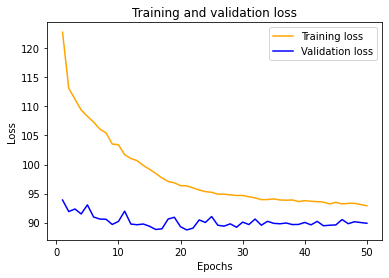

In [27]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = np.arange(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, "orange", label="Training loss")
plt.plot(epochs, val_loss, "blue", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Оценим точность

In [28]:
mse_mlp, rmse_mlp, r2_mlp = evaluate_model(y_test, y_pred_mlp)

print(f"MSE: {mse_mlp:.3f}\nRMSE: {rmse_mlp:.3f}\nR2: {r2_mlp:.3f}")

MSE: 89.273
RMSE: 9.448
R2: 0.731


#### Рассмотрим результаты с учётом доверительного интервала

In [29]:
y_pred_mlp = list(y_pred_mlp.flat)
confidence_interval_mlp = create_confidence_interval_df(y_test, y_pred_mlp)

confidence_interval_mlp.head(5)

,y_test,lower_bound,y_pred,upper_bound
788,45,44.914516,45.108131,45.301746
207109,25,31.150856,31.344469,31.538082
138644,19,35.009228,35.202843,35.396458
37164,29,37.515415,37.709030,37.902645
174351,17,22.823734,23.017347,23.210960


#### Построим график полученных результатов

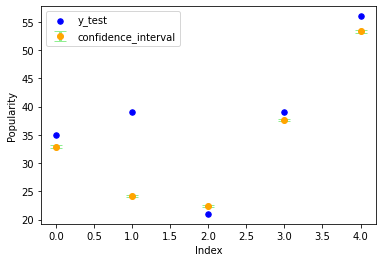

In [30]:
plot_result_sample(confidence_interval_mlp, 5)

#### Выводы по модели

### Результаты в единой таблице для наглядности

In [32]:
model_validation_df = pd.DataFrame({
    "model": ["linear", "ridge", "polynomial", "random forest", "multi-layer perceptron"],
    "mse": [mse_lr, mse_rr, mse_pf, mse_rf, mse_mlp],
    "rmse": [rmse_lr, rmse_rr, rmse_pf, rmse_rf, rmse_mlp],
    "r^2": [r2_lr, r2_rr, r2_pf, r2_rf, r2_mlp]
})

model_validation_df

,model,mse,rmse,r^2
0,linear,92.716939,9.628964,0.720202
1,ridge,92.717042,9.628969,0.720202
2,polynomial,89.369000,9.454000,0.730000
3,random forest,87.045000,9.330000,0.737000
4,multi-layer perceptron,89.272734,9.448425,0.730596


### Общий вывод
По сводному датасету метрик качества видно, что на первом месте идёт random forest, после него mlp, а далее polynomial. С учётом несуразно большого количества ресурсов, необходимых для последнего (уже степень 3 крашит бесплатный колаб по памяти), можно считать победителями 2 вышеописанные модели. Учтём также и то, что у них есть задел на улучшение, заключающийся в подборе структуры модели и гиперпараметров. 

Из данной работы стало довольно очевидно, что точно предсказать популярность песни на Spotify по датасету её характеристик довольно проблематично (либо я делал что-то совсем не так), по крайней мере без обладания внушительными вычислительными ресурсами, так как отличия метрик качества для разных моделей не слишком отличаются. В целом, такой результат является довольно логичным, иначе "формула" идеального трека была бы очевидна всем, и многие бы старались идеально ей соответствовать, а такого в реальном мире вроде пока не наблюдается. Кроме того, на популярность песни могут влиять события, которые никак не отражены в датасете (актуальная тема, какие-либо вещи, связанные с артистом / группой).

Что можно улучшить?
+ Попробовать заменить One Hot Encoding, на, к примеру, Hashing Trick или другие аналоги. Я не уверен, что это даст качественный прирост, но небольшой вполне возможен.
+ С большими вычислительными ресурсами подобрать более удачные гиперпараметры для Random Forest. Не знаю, на каком этапе остановится сходимость MSE, но задел для прогресса там точно есть.
+ Попробовать поиграться со слоями, функциями активации и прочими параметрами MLP. Лично я провёл около 5 запусков с разными параметрами, и, уверен, что можно выбрать их релевантнее, что опять же требует времени и ресурсов.